In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier, callback
from optuna.integration import XGBoostPruningCallback
import mlflow
from utils.metrics import Metrics_df,print_metrics, precision, recall, f1
import glob
from tqdm import tqdm
from utils.forest_infer import pred_multi
import pandas as pd
import numpy as np
from xgboost import XGBClassifier, callback
import mlflow
from utils.metrics import Metrics_df,print_metrics, precision, recall, f1


In [2]:


import pandas as pd
from sklearn.metrics import roc_auc_score
from Config import config
import warnings
warnings.filterwarnings("ignore")
import optuna  # pip install optuna
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GroupKFold
import numpy as np
from sklearn.model_selection import train_test_split
from datetime import datetime
import gc
import pickle
import tempfile

In [3]:
from lightgbm.basic import LightGBMError
from lightgbm import LGBMClassifier, early_stopping, log_evaluation, Booster
from sklearn.metrics import roc_auc_score
import os
from catboost import CatBoostClassifier


# Loading data and group split

In [4]:
# df_pairs = pd.read_csv("/workspace/Training_data/training/Full_training_data.csv")
# df_pairs = df_pairs.sample(frac=1).reset_index(drop=True)
# kf = GroupKFold(n_splits=5)
# for i, (trn_idx, val_idx) in enumerate(kf.split(df_pairs, df_pairs["placeId1"], df_pairs["placeId1"])):
#     df_pairs.loc[val_idx, "fold"] = i
# df_pairs["fold"].value_counts()
# df_pairs.to_csv("/workspace/Training_data/training/Full_training_data_fold.csv",index=None)

# Loading data

In [5]:
df_pairs = pd.read_csv("/workspace/Training_data/training/Full_training_data_fold_v4_without_categories.csv")

In [6]:
features = ['similarity', 'haversine', 'name_davies',
       'name_leven', 'name_dice', 'name_jaro', 'name_set_ratio',
       'street_davies', 'street_leven', 'street_jaro', 'email_davies',
       'email_leven', 'email_jaro', 'url_davies', 'url_leven', 'url_jaro',
       'brands_davies', 'brand_leven', 'brand_jaro', 'phone_lcs',
       'subcat_WRatio', 'subcat_ratio', 'subcat_token_set_ratio',
       'Is_direction_match_0', 'Is_direction_match_1', 'Is_direction_match_2',
       'Is_house_match_0', 'Is_house_match_1', 'Is_house_match_2',
       'Is_category_match_0', 'Is_category_match_1', 'Is_subcategory_match_0',
       'Is_subcategory_match_1', 'Is_subcategory_match_2', 'Is_brand_match_0',
       'Is_brand_match_1', 'Is_brand_match_2', 'Is_brand_match_3',
       'Is_related_cat_0', 'Is_related_cat_1', 'Is_name_number_match_0',
       'Is_name_number_match_1', 'Is_name_number_match_2',
       'Is_name_number_match_3', 'is_phone_match_1', 'is_phone_match_2',
       'is_phone_match_3', 'is_phone_match_4', 'Is_email_match_0',
       'Is_email_match_1', 'Is_email_match_2', 'Is_url_match_0',
       'Is_url_match_1', 'Is_url_match_2']

In [7]:
catboost_params =        {
            "min_data_in_leaf": 6227,
            'l2_leaf_reg': 0.926,
            'depth': 11,
            'border_count' : 179
        }

In [8]:
for fold in [0,1,2,3,4]:

    model = CatBoostClassifier(
        **catboost_params,
        learning_rate=0.05,
        n_estimators=10000,
        objective="Logloss",
        eval_metric="AUC",
        gpu_ram_part=0.50,
        task_type="GPU",
    )


    model.fit(df_pairs[df_pairs["fold"]!=fold][features],df_pairs[df_pairs["fold"]!=fold]["duplicate_flag"],
    eval_set=[(df_pairs[df_pairs["fold"]==fold][features], df_pairs[df_pairs["fold"]==fold]["duplicate_flag"])],verbose=100,
    early_stopping_rounds=50)
    model.save_model("/workspace/models/" + f"catboost_dedup_{fold}")



Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9986919	best: 0.9986919 (0)	total: 239ms	remaining: 39m 48s
100:	test: 0.9998948	best: 0.9998948 (100)	total: 20.7s	remaining: 33m 44s
200:	test: 0.9999187	best: 0.9999189 (199)	total: 41.2s	remaining: 33m 27s
300:	test: 0.9999290	best: 0.9999290 (299)	total: 1m 2s	remaining: 33m 24s
400:	test: 0.9999334	best: 0.9999334 (400)	total: 1m 23s	remaining: 33m 25s
500:	test: 0.9999343	best: 0.9999344 (478)	total: 1m 44s	remaining: 33m 10s
600:	test: 0.9999351	best: 0.9999352 (578)	total: 2m 6s	remaining: 32m 51s
bestTest = 0.9999351501
bestIteration = 578
Shrink model to first 579 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9986162	best: 0.9986162 (0)	total: 257ms	remaining: 42m 49s
100:	test: 0.9999137	best: 0.9999137 (100)	total: 14s	remaining: 22m 50s
200:	test: 0.9999300	best: 0.9999300 (200)	total: 23.3s	remaining: 18m 58s
300:	test: 0.9999356	best: 0.9999357 (295)	total: 32.4s	remaining: 17m 24s
400:	test: 0.9999387	best: 0.9999388 (397)	total: 41.7s	remaining: 16m 37s
500:	test: 0.9999407	best: 0.9999408 (499)	total: 51s	remaining: 16m 7s
600:	test: 0.9999415	best: 0.9999415 (596)	total: 1m	remaining: 15m 44s
bestTest = 0.9999422431
bestIteration = 646
Shrink model to first 647 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9986875	best: 0.9986875 (0)	total: 197ms	remaining: 32m 48s
100:	test: 0.9999064	best: 0.9999064 (100)	total: 9.65s	remaining: 15m 46s
200:	test: 0.9999225	best: 0.9999225 (199)	total: 19.2s	remaining: 15m 35s
300:	test: 0.9999280	best: 0.9999284 (296)	total: 28.3s	remaining: 15m 12s
400:	test: 0.9999316	best: 0.9999316 (397)	total: 37.7s	remaining: 15m 1s
500:	test: 0.9999329	best: 0.9999329 (497)	total: 47.6s	remaining: 15m 2s
600:	test: 0.9999344	best: 0.9999347 (577)	total: 57.1s	remaining: 14m 53s
700:	test: 0.9999354	best: 0.9999355 (689)	total: 1m 6s	remaining: 14m 45s
bestTest = 0.999935925
bestIteration = 724
Shrink model to first 725 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9988528	best: 0.9988528 (0)	total: 243ms	remaining: 40m 32s
100:	test: 0.9999071	best: 0.9999071 (100)	total: 10.1s	remaining: 16m 28s
200:	test: 0.9999250	best: 0.9999250 (199)	total: 19.9s	remaining: 16m 9s
300:	test: 0.9999318	best: 0.9999319 (283)	total: 29.6s	remaining: 15m 53s
400:	test: 0.9999345	best: 0.9999348 (374)	total: 39.2s	remaining: 15m 37s
500:	test: 0.9999357	best: 0.9999361 (463)	total: 48.6s	remaining: 15m 22s
bestTest = 0.9999361038
bestIteration = 463
Shrink model to first 464 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9988827	best: 0.9988827 (0)	total: 237ms	remaining: 39m 30s
100:	test: 0.9999208	best: 0.9999208 (100)	total: 9.92s	remaining: 16m 12s
200:	test: 0.9999333	best: 0.9999335 (189)	total: 19.6s	remaining: 15m 56s
300:	test: 0.9999388	best: 0.9999391 (289)	total: 29.2s	remaining: 15m 40s
400:	test: 0.9999405	best: 0.9999405 (400)	total: 38.7s	remaining: 15m 25s
bestTest = 0.999940455
bestIteration = 400
Shrink model to first 401 iterations.


# Inference validation

In [9]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 15)
plt.style.use('seaborn-whitegrid')
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['lines.markersize'] = 10
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams["legend.loc"] = 'best'


<AxesSubplot: >

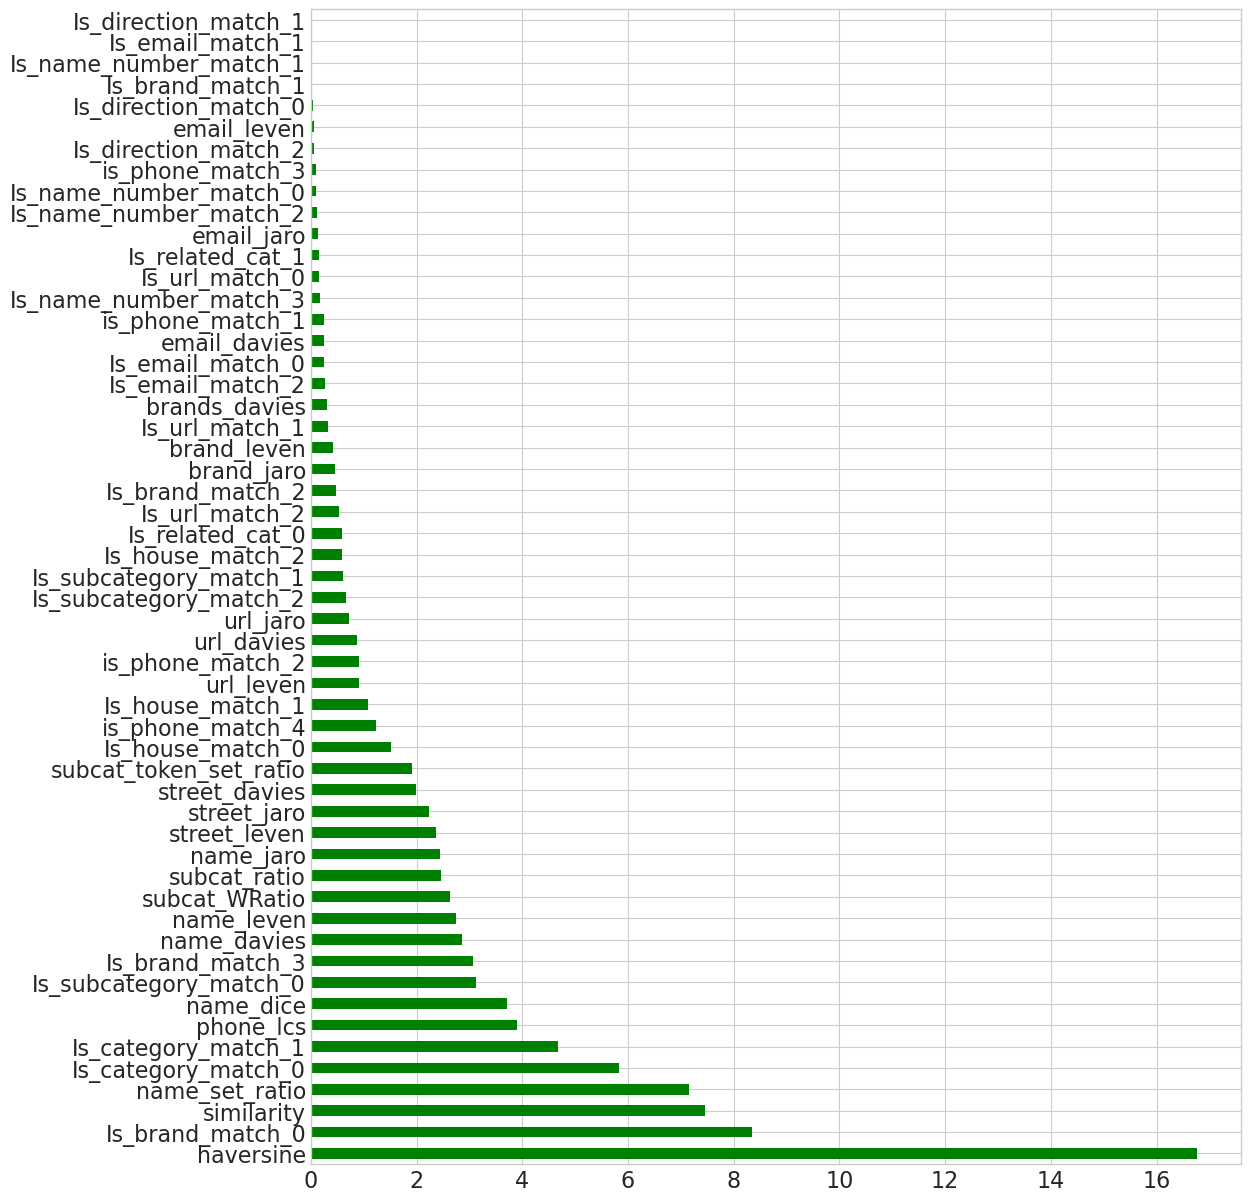

In [10]:
feat_importances = pd.Series(model.feature_importances_, index=model.feature_names_)
feat_importances.nlargest(70).plot(kind='barh', color='green')


In [11]:
models = glob.glob(f"/workspace/models/catboost_dedup_*")

In [12]:
models

['/workspace/models/catboost_dedup_0',
 '/workspace/models/catboost_dedup_1',
 '/workspace/models/catboost_dedup_2',
 '/workspace/models/catboost_dedup_3',
 '/workspace/models/catboost_dedup_4']

In [13]:
def pred_multi_catboost(model_file,df):
    xgb_model = CatBoostClassifier()
    xgb_model.load_model(model_file)
    prediction = xgb_model.predict_proba(df)[:, 1]
    del xgb_model
    gc.collect()
    return prediction

In [14]:
ltable_id = []
rtable_id = []
duplicate_flag = []
ltable_id = ltable_id + list(df_pairs["placeId1"])
rtable_id = rtable_id + list(df_pairs["placeId2"])

duplicate_flag = duplicate_flag + list(df_pairs["duplicate_flag"])
all_pred = []
for model_file in tqdm(models):
    prediction = pred_multi_catboost(model_file,df_pairs[features])
    all_pred.append(prediction)

100%|██████████| 5/5 [00:05<00:00,  1.17s/it]


In [15]:
df = pd.DataFrame(list(
    zip(ltable_id, rtable_id, all_pred[0], all_pred[1], all_pred[2],all_pred[3],all_pred[4],duplicate_flag)),
                columns=['ltable_id', 'rtable_id', 'prediction1','prediction2', 'prediction3','prediction4','prediction5','duplicate_flag'])
df["prediction"] = df["prediction1"] + df["prediction2"] + df["prediction3"] + df["prediction4"] + df["prediction5"]
df["prediction"] = df["prediction"] / 5

0.9999959812712238


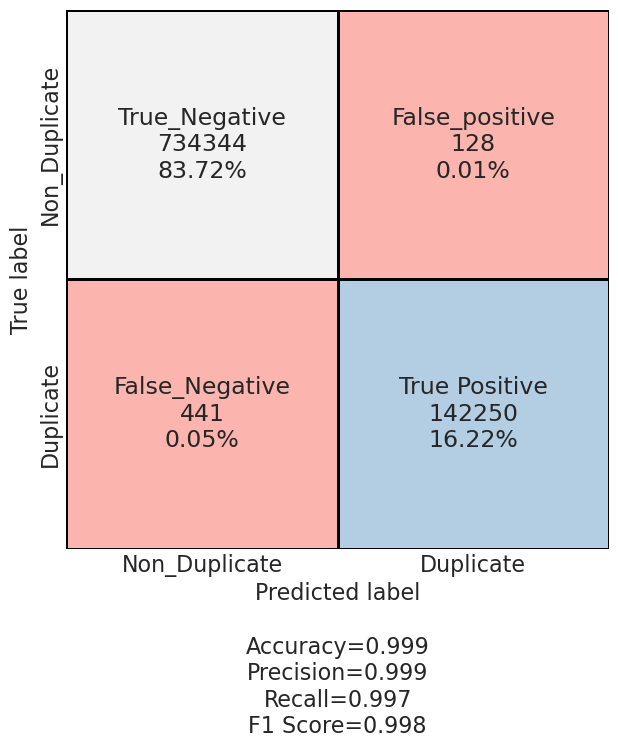

In [16]:
fig_conf= print_metrics(df["duplicate_flag"],df["prediction"])